In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import glob

In [147]:
img = mpimg.imread('./camera_cal/calibration1.jpg')

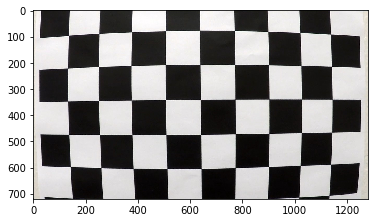

In [148]:
plt.imshow(img)

In [7]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


In [21]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [22]:
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

In [23]:
corners

array([[[  150.55474854,   168.37316895]],

       [[  278.26553345,   165.38710022]],

       [[  412.94219971,   163.44773865]],

       [[  553.00842285,   162.57493591]],

       [[  693.15905762,   164.16387939]],

       [[  830.62976074,   166.93409729]],

       [[  963.53704834,   170.36102295]],

       [[ 1088.63708496,   176.06677246]],

       [[ 1204.47570801,   182.35409546]],

       [[  175.49577332,   283.39035034]],

       [[  296.92562866,   282.52404785]],

       [[  423.63449097,   283.17852783]],

       [[  555.61584473,   283.83862305]],

       [[  687.56951904,   284.35632324]],

       [[  817.06878662,   284.55831909]],

       [[  942.58227539,   284.46170044]],

       [[ 1061.33422852,   286.90646362]],

       [[ 1172.84082031,   290.18533325]],

       [[  199.41362   ,   386.11282349]],

       [[  314.4569397 ,   387.51980591]],

       [[  434.52139282,   388.29876709]],

       [[  558.55505371,   389.72235107]],

       [[  682.57525635,   390.5

In [25]:
if ret:
    imgpoints.append(corners)
    objpoints.append(objp)

In [26]:
new_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

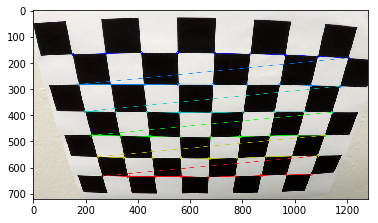

In [27]:
plt.imshow(new_img)

In [139]:
class Camera(object):
    
    pattern_size = (9, 6)
    
    def __init__(self, calibration_images='./camera_cal/calibration*.jpg'):
        self.is_calibrated = False
        self.calibration_images = calibration_images
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None
        
    def calibrate(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob(self.calibration_images)

        # Step through the list and search for chessboard corners
        for fname in images:
            img = mpimg.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, self.pattern_size, None)

            # If found, add object points, image points
            if ret:
                objpoints.append(objp)
                imgpoints.append(corners)
        assert objpoints and imgpoints, 'No object or image points found to calibrate with'
        
        image_size = gray.shape[::-1]
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                           image_size, None, None)
        
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs
        self.is_calibrated = True
    
    def undistort(self, img):
        if not self.is_calibrated:
            raise ValueError("Camera not yet calibrated with chessboard images.")
        
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

In [140]:
camera = Camera()

In [141]:
camera.calibrate()

In [143]:
for fname in glob.glob(camera.calibration_images):
    img = mpimg.imread(fname)
    undistorted = camera.undistort(img)
#     destination = fname.replace('camera_cal', 'output_images/undistorted').replace('.jpg', '_undistorted.jpg')
    cv2.imwrite(destination, undistorted)

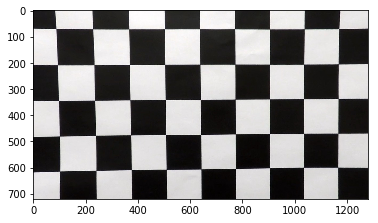

In [149]:
plt.imshow(camera.undistort(img))

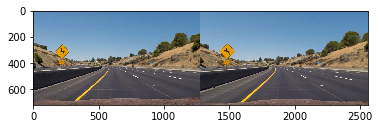

In [135]:
test_image = mpimg.imread('./test_images/test2.jpg')
undistorted = camera.undistort(test_image)

plt.imshow(np.hstack((test_image, undistorted)))


In [145]:
for fname in glob.glob('./test_images/*.jpg'):
    img = mpimg.imread(fname)
    undistorted = camera.undistort(img)
    destination = fname.replace('test_images', 'output_images/')
    cv2.imwrite(destination, undistorted)

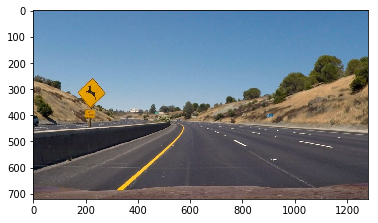

In [146]:
plt.imshow(test_image)

In [170]:
def threshold_by_color_and_gradient(img, gray_thresh=(20, 100), s_thresh=(170, 255), l_thresh=(30, 255), kernel_size=3):
    img = np.copy(img)

    # convert to HLS color space.
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))

    thresh_min, thresh_max = gray_thresh
    sx_binary = np.zeros_like(sobelx)
    sx_binary[(sobelx >= thresh_min) & (sobelx <= thresh_max)] = 1

    thresh_min, thresh_max = s_thresh
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1

    thresh_min, thresh_max = l_thresh
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh_min) & (l_channel <= thresh_max)] = 1

    # combine binary image
    combined = np.zeros_like(sx_binary)
    combined[((l_binary == 1) & (s_binary == 1) | (sx_binary == 1))] = 1
#     combined[(s_binary == 1) | (sx_binary == 1)] = 1
    return combined
#     binary = 255 * np.dstack((binary, binary, binary)).astype('uint8')

#     return noise_reduction(binary)

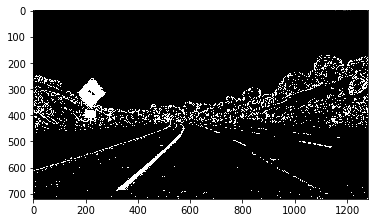

In [171]:
plt.imshow(threshold_by_color_and_gradient(test_image), cmap='gray')

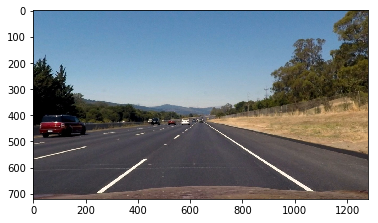

In [340]:
img = cv2.imread('./output_images/straight_lines2.jpg')
plt.imshow(img)

In [120]:
class Perspective(object):
    
    def __init__(self, src, dst):
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inverse = cv2.getPerspectiveTransform(dst, src)
    
    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inverse, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


   
    
def perspective_transform(img, src, dst):
    perspective = Perspective(src, dst)
    return perspective.transform(img)
    

In [121]:
corners = np.float32([
    [253, 697],
    [585,456],
    [700, 456],
    [1061,690]
])

top_left = np.array([corners[0, 0], 0])
top_right = np.array([corners[3, 0], 0])

img_size = (img.shape[1], img.shape[0])
offset = [50, 0]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, top_left + offset, top_right - offset, corners[3] - offset])

perspective = Perspective(src, dst)

In [215]:
None or src

array([[  253.,   697.],
       [  585.,   456.],
       [  700.,   456.],
       [ 1061.,   690.]], dtype=float32)

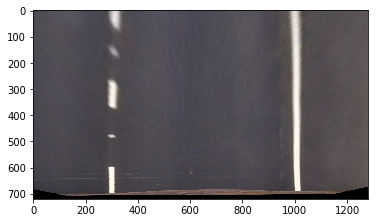

In [122]:
plt.imshow(perspective.transform(img))

In [123]:
transformed = perspective.transform(img)

In [352]:
def draw_box(img, color=(255, 0, 0), thickness=10):
    img = img.copy()
    cv2.line(img, (230, 720), (1050,720), color=color, thickness=thickness)
    cv2.line(img, (230, 720), (600,450), color=color, thickness=thickness)
    cv2.line(img, (1100, 720), (700,450), color=color, thickness=thickness)
    cv2.line(img, (600, 450), (700,450), color=color, thickness=thickness)
    return img


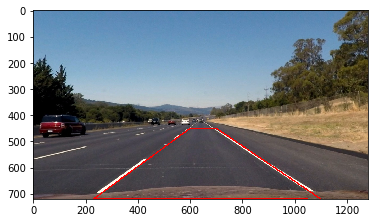

In [357]:
plt.imshow(draw_box(img, thickness=3))

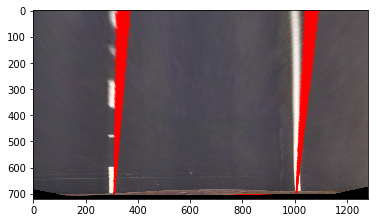

In [358]:
plt.imshow(perspective.transform(draw_box(img, thickness=3)))

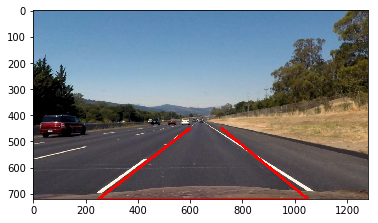

In [345]:
plt.imshow(draw_box(img))

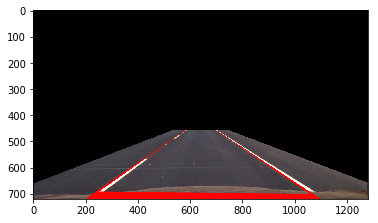

In [127]:
plt.imshow(perspective.inverse_transform(draw_box(transformed)))

In [172]:
def process_image(img):
    img = camera.undistort(img)
    img = threshold_by_color_and_gradient(img)
    img = perspective.transform(img)
    return img

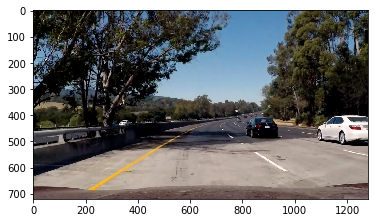

In [284]:
img = mpimg.imread('./test_images/test5.jpg')
processed = process_image(img)

plt.imshow(img)

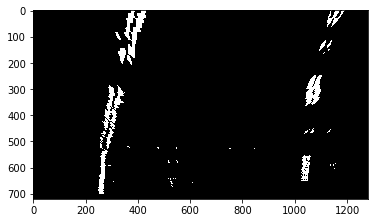

In [174]:
plt.imshow(processed, cmap='gray')

In [179]:
binary_warped = processed

In [180]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

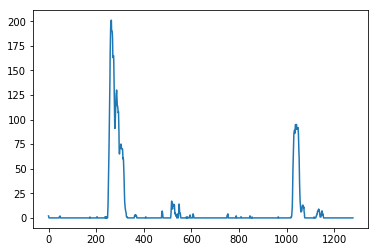

In [181]:
plt.plot(histogram)

In [184]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [185]:
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [186]:
left_fit

array([  1.88321212e-04,  -3.44052757e-01,   4.05670200e+02])

In [187]:
right_fit

array([  3.12295730e-04,  -3.86566874e-01,   1.16117021e+03])

In [188]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

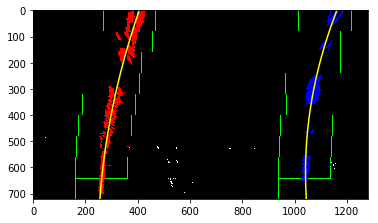

In [190]:
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [193]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

(2676.4335968591831, 1610.4411595733231)


In [196]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
# left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
# right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# # Calculate the new radii of curvature
# left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
# right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# # Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')

In [195]:
leftx

array([255, 256, 257, ..., 408, 409, 410])

In [198]:
class Line(object):
    
    def __init__(self):
        self.camera = Camera()
        self.camera.calibrate()
        
        self.perspective = Perspective(src, dst)
        
    def preprocess(self, img):
        """Apply undsitrtion, perspective tnrasofmr, etc."""
        img = camera.undistort(img)
        img = threshold_by_color_and_gradient(img)
        img = perspective.transform(img)
    
    
    def draw(self, img):
        pass
    


In [199]:
def fit_lines(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [201]:
left_fitx = left_fit[0] * fity ** 2 + left_fit[1] * fity + left_fit[2]
right_fitx = right_fit[0] * fity ** 2 + right_fit[1] * fity + right_fit[2]


NameError: name 'fity' is not defined

In [210]:
def draw(undist, warped, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp = perspective.inverse_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

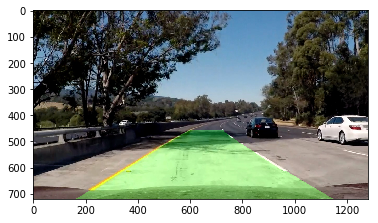

In [212]:
plt.imshow(draw(img, binary_warped, left_fit, right_fit))

In [232]:
def is_close_parallel(left_fit, right_fit, relative_epsilon=0.5):
    A_left, A_right = left_fit[0], right_fit[0]
    B_left, B_right = left_fit[1], right_fit[1]
    A = abs(1.0 - A_left / A_right) < relative_epsilon
    B = abs(1.0 - B_left / B_right) < relative_epsilon
    return A and B



def 

def is_close_distance(left_fit, right_fit, absolute_epsilon=):
    left_fit 

In [231]:
is_close_parallel(left_fit, right_fit, 0.4)

True

In [217]:
right_fit

array([  3.12295730e-04,  -3.86566874e-01,   1.16117021e+03])

In [218]:
left_fit[0]

0.00018832121188545444

In [219]:
right_fit[0]

0.00031229573037391811

In [220]:
left_fit[0] / right_fit[0]

0.60302205111793739

In [221]:
left_fit[1]

-0.34405275699024102

In [222]:
right_fit[1]

-0.38656687411879137

In [225]:
1 - left_fit[1] / right_fit[1]

0.10997868667734279

In [233]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

(2676.4335968591831, 1610.4411595733231)


In [236]:
leftx.shape

(18269,)

In [238]:
ploty.shape

(720,)

In [234]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

TypeError: expected x and y to have same length

In [253]:
def eval_fit(fit, y):
    return fit[0] * y**2 + fit[1] * y + fit[2]


def compute_curvature(fit):
    ym_per_pix = 30. / 720  # meters per pixel
    xm_per_pix = 3.7 / 700  # meters per pixel 

    ys = np.array(np.linspace(0, 719, num=10))
    xs = np.array([eval_fit(fit, y) for y in ys])
    y_eval = np.max(y)

    fit_cr = np.polyfit(ys * ym_per_pix, xs * xm_per_pix, 2)
    curverad = ((1 + (2 * fit_cr[0] * y_eval / 2. + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])

    return curverad

In [255]:
compute_curvature(right_fit)

873.63048180150997

In [249]:
ys * 230

array([      0.        ,   18374.44444444,   36748.88888889,
         55123.33333333,   73497.77777778,   91872.22222222,
        110246.66666667,  128621.11111111,  146995.55555556,  165370.        ])

In [248]:
xs.shape

(10,)

In [256]:
import math

In [258]:
1 - 873 / 1000.

0.127

In [277]:
import collections
d = collections.deque(maxlen=10)
for i in xrange(20):
    left = np.array([i, i])
    right = np.array([i*2, i*2])
    d.append((left, right))

In [276]:
np.mean(d, axis=0)

array([ 14.5,  14.5])

In [280]:
left, right = zip(*d)

In [283]:
1200 / 50.

24.0

In [265]:
left_fit

array([  1.88321212e-04,  -3.44052757e-01,   4.05670200e+02])

In [268]:
np.sum([left_fit, left_fit], axis=0)

array([  3.76642424e-04,  -6.88105514e-01,   8.11340400e+02])

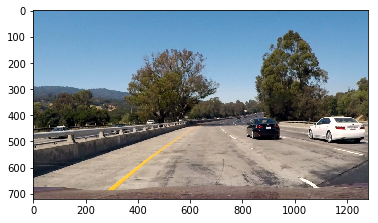

In [292]:
img = mpimg.imread('./test_images/test1.jpg')
processed = process_image(img)

plt.imshow(img)

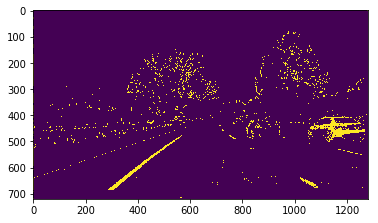

In [329]:
plt.imshow(threshold_by_color_and_gradient(img, gray_thresh=(40, 100), kernel_size=3),)

In [294]:
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

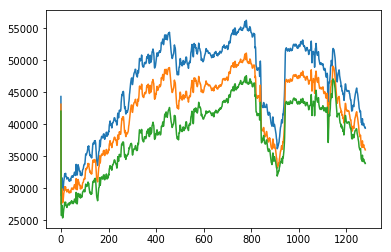

In [295]:
plt.plot(histogram)

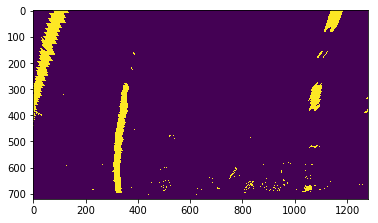

In [296]:
plt.imshow(process_image(img))

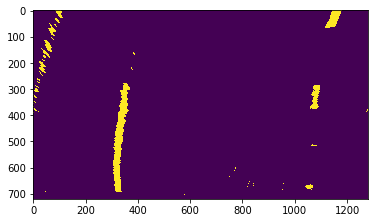

In [323]:
plt.imshow(perspective.transform(threshold_by_color_and_gradient(img, gray_thresh=(40, 100))))

In [335]:
def compute_offset(left_fit, right_fit, image_size):
    xm_per_pix = 3.7 / 700
    
    length, width = image_size
    bottom_pixel = length
    left_lane = left_fit[0] * bottom_pixel ** 2 + left_fit[1] * bottom_pixel + left_fit[2]
    right_lane = right_fit[0] * bottom_pixel ** 2 + right_fit[1] * bottom_pixel + right_fit[2]
    
    center = (left_lane + right_lane) / 2.
    offset = (center - width / 2.) * xm_per_pix
    return offset

In [336]:
compute_offset(left_fit, right_fit, img.shape[:2])

0.053687267663738686

In [333]:
img.shape[:2]

(720, 1280)